# **Walker SAC**

### **Imports**

In [53]:
from rlkit.util import MultiVersionCheckpointer, Checkpointer, Logger, SimpleMetricModule, Stopwatch
from config import *

import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from env import create_env

# Import Torch
import torch
from torch import nn
from torch import optim
from torchinfo import summary

# Models and Loss
from rlkit.models import MLP, CatWrapper
from tensordict.nn import TensorDictModule
from torchrl.modules import ProbabilisticActor, TanhNormal
from tensordict.nn.distributions import NormalParamExtractor

# Data
from tensordict import TensorDict
from torchrl.collectors import SyncDataCollector, MultiaSyncDataCollector, aSyncDataCollector
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

# Util
from torchrl.objectives import SACLoss, SoftUpdate, ValueEstimators

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_type = "cuda" if str(device).startswith("cuda") else "cpu"
amp_dtype   = torch.float16 if device_type == "cuda" else torch.float32
device, amp_dtype

(device(type='cpu'), torch.float32)

## Models

In [2]:
def create_policy(model_config):
    model_config = model_config.copy()
    model_config["out_features"] *= 2
    model = MLP(**model_config)

    model = nn.Sequential(
        model,
        NormalParamExtractor()
    )
    model = TensorDictModule(model, in_keys=["observation"], out_keys=["loc", "scale"])
    
    policy = ProbabilisticActor(
        module=model,  
        distribution_class=TanhNormal,

        in_keys=["loc", "scale"],
        out_keys=["action"],

        return_log_prob=True,
        log_prob_key="log_prob",
        cache_dist=True,
    )

    return policy

def create_qvalue(model_config):
    # Remove out_features from config
    model_config = model_config.copy()
    model_config["in_features"] = model_config["in_features"] + model_config["out_features"]
    model_config["out_features"] = 1

    model = MLP(**model_config)
    model = CatWrapper(model)
    qvalue = TensorDictModule(model, in_keys=["observation", "action"], out_keys=["state_action_value"])
    return qvalue

In [3]:
policy = create_policy(MODEL_CONFIG)
qvalue = create_qvalue(MODEL_CONFIG)

In [4]:
samples = (torch.randn(1, MODEL_CONFIG["in_features"]), torch.randn(1, MODEL_CONFIG["out_features"]))
summary(qvalue, input_data=samples)

Layer (type:depth-idx)                        Output Shape              Param #
TensorDictModule                              [1, 1]                    --
├─CatWrapper: 1-1                             [1, 1]                    --
│    └─MLP: 2-1                               [1, 1]                    --
│    │    └─Linear: 3-1                       [1, 128]                  36,224
│    │    └─ModuleList: 3-2                   --                        393,600
│    │    └─Sequential: 3-3                   [1, 1]                    257
Total params: 430,081
Trainable params: 430,081
Non-trainable params: 0
Total mult-adds (M): 0.43
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.72
Estimated Total Size (MB): 1.75

In [5]:
samples = torch.randn(1 ,MODEL_CONFIG["in_features"])
summary(policy.module[0], input_data=samples)

Layer (type:depth-idx)                        Output Shape              Param #
TensorDictModule                              [1, 39]                   --
├─Sequential: 1-1                             [1, 39]                   --
│    └─MLP: 2-1                               [1, 78]                   --
│    │    └─Linear: 3-1                       [1, 128]                  31,232
│    │    └─ModuleList: 3-2                   --                        393,600
│    │    └─Sequential: 3-3                   [1, 78]                   10,190
│    └─NormalParamExtractor: 2-2              [1, 39]                   --
│    │    └─biased_softplus: 3-4              [1, 39]                   --
Total params: 435,022
Trainable params: 435,022
Non-trainable params: 0
Total mult-adds (M): 0.44
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 1.74
Estimated Total Size (MB): 1.77

In [6]:
# loss_module = SACLoss(
#     actor_network=policy, qvalue_network=qvalue, value_network=None,
#     num_qvalue_nets=2,
#     alpha_init=0.1, fixed_alpha=True, 
#     delay_actor=False, delay_qvalue=True
# )
# target_updater = SoftUpdate(loss_module, tau=0.005)

In [7]:
# try: env.close()
# except: pass
# env = create_env(graphics=False, time_scale=10)

# with torch.no_grad():
#     data = env.rollout(100, policy=policy, break_when_any_done=False)
# data, loss_module(data)

## Train

### Config

In [8]:
TIME_SCALE = 5

In [61]:
WORKERS = os.cpu_count() // 2
TIMESTEPS = 30_000_000
BUFFER_SIZE = 3_000_000
BATCH_SIZE = 256

# ENTROPY_TARGET = 1e-3
ENTROPY_COEF = 1e-3
# print("Entropy Target:", ENTROPY_TARGET)
GAMMA = 0.95
TAU = 0.005

LR = 1e-5

TRAIN_STEPS = 64
ENV_STEPS = 1000 * WORKERS
# Steps = N*K, train_iters = K. K helps with buffering async collected data with less stalls

CKPT_EVAL_INTERVAL = 100
EVAL_STEPS = 1000

In [62]:
NAME = 'run0'
CONTINUE = False

### State

In [63]:
policy = create_policy(MODEL_CONFIG).to(device)
qvalue = create_qvalue(MODEL_CONFIG).to(device)

loss_module = SACLoss(
    actor_network=policy, qvalue_network=qvalue, value_network=None,
    num_qvalue_nets=2,
    alpha_init=ENTROPY_COEF, fixed_alpha=True,
    # target_entropy=ENTROPY_TARGET, fixed_alpha=False,
    delay_actor=False, delay_qvalue=True
)
loss_module.make_value_estimator(gamma=GAMMA)
target_updater = SoftUpdate(loss_module, tau=TAU)

optimizer = optim.Adam(loss_module.parameters(), lr=LR)

replay_buffer = TensorDictReplayBuffer(
    storage = LazyMemmapStorage(max_size=BUFFER_SIZE, ndim=2),
    batch_size = BATCH_SIZE,
)

In [64]:
logger = Logger(keys = LOG_KEYS, log_path=LOG_PATH, name=NAME)
checkpointer = MultiVersionCheckpointer(ckpt_path=CKPT_PATH, name=NAME, metric_key="score", levels=10, base_interval=10, interval_scale=1.75)

# Continue/Reset
start_timestep = 0
if not CONTINUE:
    logger.reset()
    checkpointer.reset()
else:
    checkpoint = checkpointer.load_progress()
    if checkpoint:
        start_timestep = checkpoint['timestep']
        print(f"Found checkpoint at timestep: {start_timestep}")
        logger.revert("timestep", start_timestep)
        loss_module.load_state_dict(checkpoint["loss_module"], strict=False)
    else:
        print("Checkpoint not found, restarting")
        logger.reset()

In [65]:
collector = MultiaSyncDataCollector(
    [lambda: create_env(graphics=False, time_scale=TIME_SCALE)]*WORKERS, policy, 
    frames_per_batch = ENV_STEPS, 
    total_frames = TIMESTEPS - start_timestep, 
    env_device="cpu", device=device, storing_device="cpu",
    reset_at_each_iter=False,
)
short_watch, long_watch = Stopwatch(), Stopwatch()
metric_module = SimpleMetricModule(mode="approx")

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/collectors/collectors.py:2137: UserWarning: total_frames (30000000) is not exactly divisible by frames_per_batch (7000). This means 2000 additional frames will be collected. To silence this message, set the environment variable RL_WARNINGS to False.
  warnings.warn(


[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [ ]:
eval_env = create_env(graphics=False, time_scale=TIME_SCALE)
short_watch.start(); long_watch.start()
for i, data in enumerate(collector):
    # 1. Extend
    replay_buffer.extend(data)
    logger.add({"collect_wait_time": short_watch.end(), "timestep": ENV_STEPS})
    avg_reward = data["next", "reward"].mean().cpu().item()
    score = (avg_reward / BENCH_AVG_REWARD) * 100
    logger.acc({"score": score})

    # 2. Train Loop
    short_watch.start()
    for j in range(TRAIN_STEPS):
        batch = replay_buffer.sample().to(device)

        # 1. SAC Loss
        loss_data = loss_module(batch)
        loss = loss_data["loss_actor"] + loss_data["loss_qvalue"] + loss_data["loss_alpha"]
        
        # 2. Update
        optimizer.zero_grad(); loss.backward()
        optimizer.step(); target_updater.step()

        # 3. Log Metrics
        logger.acc({
            "policy_loss":  loss_data["loss_actor"].detach().cpu().item(),
            "qvalue_loss":  loss_data["loss_qvalue"].detach().cpu().item(),
            "entropy":      loss_data["entropy"].detach().cpu().item(),
            "td_error":     batch["td_error"].detach().mean().cpu().item(),
            "alpha":        loss_data["alpha"].detach().mean().cpu().item(),
        }, mode='ema')
    logger.add({"train_time": short_watch.end()})


    # 3. Sync Policy
    collector.update_policy_weights_()

    # 4. Checkpoint and eval
    if (i+1) % CKPT_EVAL_INTERVAL == 0:
        eval_env.reset()
        with torch.no_grad():
            data = eval_env.rollout(EVAL_STEPS, policy=policy, break_when_any_done=False, auto_cast_to_device=True)
        metrics = metric_module(data)
        metrics["eval_entropy"] = metrics["entropy"]
        del metrics["entropy"]
        logger.acc(metrics)
        checkpointer.save_progress(state_obj={
            "timestep": logger.last()["timestep"],
            "loss_module": loss_module.state_dict(),
        })
    else:
        logger.add({key: 0 for key in ["return", "episode_length", "eval_entropy"]})

    # 5. Log
    logger.add({"time": long_watch.end()})
    short_watch.start(); long_watch.start()
    logger.next(print_row=True)
collector.shutdown()


[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'continuous_action' is unaccounted for by the transform (expected keys ['VectorSensor_size243', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


ERROR: Shader UI/Default shader is not supported on this GPU (none of subshaders/fallbacks are suitable)
Thread 0x16d0a7000 may have been prematurely finalized
Setting up 7 worker threads for Enlighten.
Thread 0x16bb93000 may have been prematurely finalized
Thread 0x16bc1f000 may have been prematurely finalized
Memory Statistics:
[ALLOC_TEMP_TLS] TLS Allocator
  StackAllocators : 
    [ALLOC_TEMP_MAIN]
      Peak usage frame count: [2.0 MB-4.0 MB]: 1 frames
      Initial Block Size 4.0 MB
      Current Block Size 4.0 MB
      Peak Allocated Bytes 2.1 MB
      Overflow Count 0
    [ALLOC_TEMP_Background Job.worker 4]
      Initial Block Size 32.0 KB
      Current Block Size 32.0 KB
      Peak Allocated Bytes 0 B
      Overflow Count 0
    [ALLOC_TEMP_Loading.PreloadManager]
      Initial Block Size 256.0 KB
      Current Block Size 256.0 KB
      Peak Allocated Bytes 92.6 KB
      Overflow Count 5
    [ALLOC_TEMP_Background Job.worker 3]
      Initial Block Size 32.0 KB
      Current Bl

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


    timestep        time  collect_wait_time  train_time     score  \
99    700000  307.652347           11.89005  283.836644 -1.439175   

    policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
99    -0.114682     0.000554  0.001  22.107883  0.022432 -0.009265   

    episode_length  eval_entropy  
99       22.075056     22.243607  
     timestep        time  collect_wait_time  train_time     score  \
100    707000  310.500867          11.900007  286.675122 -1.769534   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
100    -0.117102     0.000533  0.001  22.154224  0.021901 -0.009265   

     episode_length  eval_entropy  
100       22.075056     22.243607  
     timestep        time  collect_wait_time  train_time     score  \
101    714000  314.121662          11.910159  290.285707 -1.832091   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
101    -0.118425     0.000538  0.001  22.195711  0.021859 -0.009265   

     episo

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


     timestep        time  collect_wait_time  train_time     score  \
199   1400000  616.766218          12.877784  579.050015 -1.516323   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
199    -0.175129     0.000412  0.001  23.240807  0.019943  0.008544   

     episode_length  eval_entropy  
199       26.385223     22.819235  
     timestep        time  collect_wait_time  train_time    score  \
200   1407000  619.795484           12.88823  582.068778 -1.33681   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
200    -0.175965      0.00043  0.001  23.294484  0.020012  0.008544   

     episode_length  eval_entropy  
200       26.385223     22.819235  
     timestep        time  collect_wait_time  train_time    score  \
201   1414000  622.726648            12.8971  584.991018 -0.91392   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
201     -0.17652      0.00041  0.001  23.530222  0.019802  0.008544   

     epi

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


     timestep        time  collect_wait_time  train_time     score  \
299   2100000  913.650318          13.941284   861.81834 -1.034093   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
299    -0.179566     0.000374  0.001  23.860295  0.018905  0.018342   

     episode_length  eval_entropy  
299       27.100271     23.972837  
     timestep       time  collect_wait_time  train_time     score  \
300   2107000  916.93648          13.953078  865.092645 -0.935737   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
300    -0.180885     0.000371  0.001  23.713293  0.018768  0.018342   

     episode_length  eval_entropy  
300       27.100271     23.972837  
     timestep        time  collect_wait_time  train_time     score  \
301   2114000  920.064396          13.963978  868.209598 -0.696524   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
301    -0.181527     0.000357  0.001  23.676685  0.018555  0.018342   

     e

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


     timestep         time  collect_wait_time   train_time     score  \
399   2800000  1212.378917          15.212761  1146.379683 -1.202088   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
399     -0.18943     0.000341  0.001  23.792093  0.017745  0.010258   

     episode_length  eval_entropy  
399       26.595745     24.020399  
     timestep         time  collect_wait_time   train_time     score  \
400   2807000  1215.170283          15.224733  1149.158935 -1.011413   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
400    -0.190367     0.000346  0.001  23.603161  0.017748  0.010258   

     episode_length  eval_entropy  
400       26.595745     24.020399  
     timestep         time  collect_wait_time   train_time     score  \
401   2814000  1217.923084          15.234078  1151.902337 -0.692845   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
401    -0.187988      0.00033  0.001  23.959699  0.017595  0.010

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


     timestep         time  collect_wait_time   train_time     score  \
499   3500000  1507.633051          16.127705  1427.795154 -0.769447   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
499    -0.197645     0.000278  0.001  24.372351  0.016021 -0.006959   

     episode_length  eval_entropy  
499       29.585798     25.903584  
     timestep         time  collect_wait_time   train_time     score  \
500   3507000  1510.871095          16.136635  1431.024214 -0.431446   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
500    -0.198885     0.000285  0.001  24.339123  0.016158 -0.006959   

     episode_length  eval_entropy  
500       29.585798     25.903584  
     timestep         time  collect_wait_time   train_time     score  \
501   3514000  1513.803487          16.149011  1433.944179 -0.971783   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
501    -0.198109     0.000279  0.001  24.128434  0.015932 -0.006

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


     timestep        time  collect_wait_time   train_time     score  \
599   4200000  1803.80254           16.94651  1710.191517 -0.601308   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
599    -0.202807     0.000263  0.001  24.357749  0.015189  0.010355   

     episode_length  eval_entropy  
599       28.985508     26.355778  
     timestep         time  collect_wait_time   train_time     score  \
600   4207000  1806.900962          16.954601  1713.281788 -0.770226   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
600    -0.203786     0.000265  0.001  24.425167  0.015259  0.010355   

     episode_length  eval_entropy  
600       28.985508     26.355778  
     timestep         time  collect_wait_time   train_time     score  \
601   4214000  1809.953996          16.968625  1716.320064 -0.704268   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
601    -0.202773     0.000259  0.001  24.384672  0.015095  0.01035

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


     timestep         time  collect_wait_time   train_time     score  \
699   4900000  2100.547309          17.755755  1992.819153 -0.775177   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
699    -0.206305     0.000253  0.001  24.364127  0.014751  0.012556   

     episode_length  eval_entropy  
699        30.30303      26.45713  
     timestep         time  collect_wait_time   train_time    score  \
700   4907000  2103.383443          17.764089  1995.646897 -0.70845   

     policy_loss  qvalue_loss  alpha   entropy  td_error    return  \
700    -0.207647      0.00025  0.001  24.40233  0.014718  0.012556   

     episode_length  eval_entropy  
700        30.30303      26.45713  
     timestep         time  collect_wait_time   train_time     score  \
701   4914000  2107.002554          17.777694  1999.252351 -0.478672   

     policy_loss  qvalue_loss  alpha   entropy  td_error    return  \
701    -0.207937     0.000255  0.001  24.60194  0.014765  0.012556   

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


     timestep         time  collect_wait_time   train_time     score  \
799   5600000  2401.076548            18.5731  2279.464277 -0.590985   

     policy_loss  qvalue_loss  alpha    entropy  td_error  return  \
799    -0.210101     0.000241  0.001  24.665252  0.014298  0.0138   

     episode_length  eval_entropy  
799        28.40909     27.149452  
     timestep         time  collect_wait_time   train_time     score  \
800   5607000  2403.933929          18.581455  2282.313216 -0.594764   

     policy_loss  qvalue_loss  alpha    entropy  td_error  return  \
800    -0.210638     0.000249  0.001  24.454633   0.01448  0.0138   

     episode_length  eval_entropy  
800        28.40909     27.149452  
     timestep        time  collect_wait_time   train_time     score  \
801   5614000  2407.15357          18.589662  2285.524595 -0.682103   

     policy_loss  qvalue_loss  alpha    entropy  td_error  return  \
801    -0.209748     0.000246  0.001  24.671191  0.014365  0.0138   

     e

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


     timestep         time  collect_wait_time   train_time     score  \
899   6300000  2701.660437          19.380404  2565.411603 -0.723169   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
899    -0.212316     0.000232  0.001  24.605127  0.013933  0.012597   

     episode_length  eval_entropy  
899       30.030029     26.989843  
     timestep         time  collect_wait_time   train_time    score  \
900   6307000  2704.680769          19.389917  2568.422358 -0.26645   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
900    -0.209495      0.00023  0.001  24.637315  0.014082  0.012597   

     episode_length  eval_entropy  
900       30.030029     26.989843  
     timestep         time  collect_wait_time   train_time   score  \
901   6314000  2707.591922          19.400791  2571.322587 -0.6982   

     policy_loss  qvalue_loss  alpha    entropy  td_error    return  \
901    -0.212432     0.000234  0.001  24.674427   0.01411  0.012597   

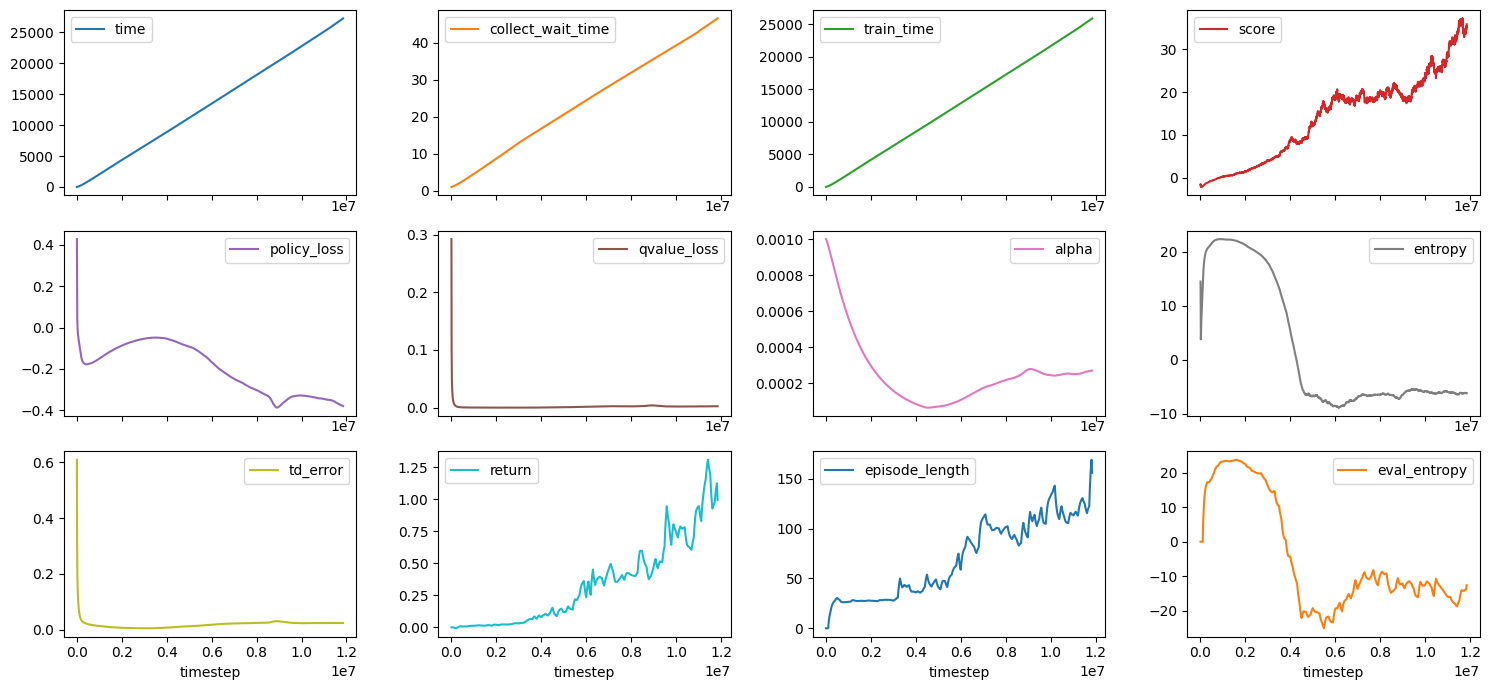

In [49]:
import os
def plot(name, alpha=0):
    # Get dataframe
    logger = Logger(keys = LOG_KEYS, log_path=LOG_PATH, name=name)
    logger.revert()
    df = logger.dataframe()
    df = df.set_index(LOG_INDEX)
    if alpha>0:
        df = df.ewm(alpha=alpha).mean()

    # Plot it
    rows = (len(df.columns) + 3) // 4
    df.plot(subplots=True, layout=(rows,4), figsize=(15, int(rows* 7/3)))
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, f"{name}.png"))
plot("run0", alpha=0.01)

In [26]:
env = create_env(graphics=True, time_scale=5)
env.reset()

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'continuous_action' is unaccounted for by the transform (expected keys ['VectorSensor_size243', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


TensorDict(
    fields={
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([10, 243]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([10]),
    device=cpu,
    is_shared=False)

In [50]:
with torch.no_grad():
    data = env.rollout(1000, policy=policy, break_when_any_done=False)

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


In [28]:
env.close()

In [29]:
SimpleMetricModule(mode="approx")(data)

{'return': 4.451180934906006,
 'episode_length': 909.0908813476562,
 'entropy': 14.313319206237793}